# Tarea 2. NN with Linear Regression, Problema 1

## Fundamentos de inteligencia computacional
## por: Juan Pablo Arango A. & Simón Zapata Caro

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from pandas.tools.plotting import scatter_matrix
from matplotlib.artist import setp
import time

plt.rcParams['figure.figsize'] = (10,16)

In [2]:
df1     = pd.io.excel.read_excel("DatosPunto1.xlsx", sheetname=0)
labels = df1.iloc[:,-2].copy()
df1 = df1.iloc[:,0:-2].copy()

X = np.array(df1)
y = np.array(labels)
X_original = X
y_original = y

In [3]:
Nsamples = X.shape[0]
Ntrain   = int(0.7*Nsamples)
Nval     = int(0.15*Nsamples)
Ntest    = Nsamples-Ntrain-Nval

X_test = X[(Nsamples-Ntest):Nsamples,:]
y_test = y[(Nsamples-Ntest):Nsamples ]

Xv = X[0:(Nsamples-Ntest),:]
yv = y[0:(Nsamples-Ntest)  ]

minimo    = np.min(X,axis=0)
maximo    = np.max(X,axis=0)

In [4]:
def derivating(fx):
    difcoefs = [1,-1]
    return np.convolve(fx,difcoefs,mode='same')

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

def clearList(L): #arroja una lista de L elementos vacios, no sabia de qué otra forma hacerla
    listica = []
    for i in range(0,L):
        listica.append([]);
    return listica

def LinearRegression(X,y,miu=0.1,iteraciones=5000,tol=0.001):   
    if X.ndim > 1:
        [M,N] = X.shape
    else:
        M = X.shape[0]
        N = 1
        X = X[:,None]
        
    VectorBias = np.ones(shape=(M,1))
    X = np.concatenate((VectorBias,X),axis=1)
    
    theta = np.random.rand(N+1,)
    
    for j in range(0,iteraciones):
        h_x = []
        h_x = np.dot(X,theta)
        J = 1/(2*M)*np.dot((h_x-y).T,(h_x-y))
        
        dJ_dtheta = np.dot((h_x-y).T,X).T
        theta = theta - miu/M * dJ_dtheta
        theta[1:] = theta[1:] - miu*0.1/M*theta[1:] #Regularization
    return [theta,h_x,J]

def Predict(X,theta):
    if X.ndim > 1:
        [M,N] = X.shape
    else:
        M = X.shape[0]
        N = 1
        X = X[:,None]

    X = np.insert(X,0,1)
    return np.dot(X,theta)


### Entrenamiento de la red neuronal usando validación cruzada con 10 folds para $\alpha = logspace(10^{-4}, 10^{-1}, N = 10)$

In [5]:
from sklearn.model_selection import KFold
X = (Xv-minimo)/(maximo-minimo)
y = yv
Nf = 10
N  = X.shape[0]
minE_val = np.inf
kf = KFold(n_splits=Nf)
alpha = np.logspace(-4,-1,num=10)

ecm_train = np.zeros((Nf,len(alpha)))
ecm_val   = np.zeros((Nf,len(alpha)))
k=0
for train_index, test_index in kf.split(X):
    wLMS       = clearList(len(alpha))
    predicted1  = clearList(len(alpha))
    predicted2 = clearList(len(alpha))
    ecm1       = clearList(len(alpha))
    ecm2       = clearList(len(alpha))
    for i in range(len(alpha)):
        [wLMS[i],predicted1[i],E] = LinearRegression(X[train_index],y[train_index],miu=alpha[i],iteraciones=1000)
        ecm1[i] = (np.sum((np.abs(predicted1[i]-y[train_index])))/y[train_index].shape)[0]
        
        p_i = []
        for j in range(0,X[test_index].shape[0]):
            p_i.append(Predict(X[test_index][j,:],wLMS[i]))
        predicted2[i] = p_i
        ecm2[i] = (np.sum((np.abs(predicted2[i]-y[test_index])))/y[test_index].shape)[0]
        
        if(ecm2[i] < minE_val):
            wLMS_optimo = wLMS[i]
            minE_val = ecm2[i]
            alphaOptimo = alpha[i]
        print('validación ',(k+1),' Función de error: ',str(E),', con alpha: ',str(alpha[i]))
    ecm_train[k,:] = ecm1
    ecm_val[k,:]   = ecm2
    k+=1


validación  1  Función de error:  149.00970584274464 , con alpha:  0.0001
validación  1  Función de error:  91.38194406643981 , con alpha:  0.00021544346900318845
validación  1  Función de error:  44.025638164016144 , con alpha:  0.00046415888336127773
validación  1  Función de error:  21.74522447052944 , con alpha:  0.001
validación  1  Función de error:  11.393148767661422 , con alpha:  0.002154434690031882
validación  1  Función de error:  6.520210769444874 , con alpha:  0.004641588833612777
validación  1  Función de error:  5.015475554681364 , con alpha:  0.01
validación  1  Función de error:  4.310447874218741 , con alpha:  0.021544346900318822
validación  1  Función de error:  4.14879346484933 , con alpha:  0.046415888336127774
validación  1  Función de error:  4.004623596383246 , con alpha:  0.1
validación  2  Función de error:  148.84506402667688 , con alpha:  0.0001
validación  2  Función de error:  91.08406104698865 , con alpha:  0.00021544346900318845
validación  2  Función 

In [6]:
d  = {'1. alpha':alpha,'2. error de entrenamiento: ': np.mean(ecm_train,axis = 0),'3. error de validación':np.mean(ecm_val,axis = 0)}
df = pd.DataFrame(data=d)
df

,1. alpha,2. error de entrenamiento:,3. error de validación
0,0.000100,14.426164,14.486253
1,0.000215,10.258553,10.381326
2,0.000464,7.141220,7.154593
3,0.001000,5.383726,5.438845
4,0.002154,3.834720,3.880148
5,0.004642,2.807691,2.913885
6,0.010000,2.365361,2.473039
7,0.021544,2.216635,2.365051
8,0.046416,2.201524,2.380102
9,0.100000,2.175060,2.374729


In [7]:
prediction_testing = []
X_test = X_original[(Nsamples-Ntest):Nsamples,:]
y_test = y_original[(Nsamples-Ntest):Nsamples  ]

X_test = (X_test-minimo)/(maximo-minimo)

for j in range(0,X_test.shape[0]):
    prediction_testing.append(Predict(X_test[j,:],wLMS_optimo))
ecm_testing = (np.sum((np.abs(prediction_testing-y_test)))/y_test.shape)[0]
print('error de testeo: '+str(ecm_testing))

d = {'1. predicción': prediction_testing, '2. label' : y_test}
df = pd.DataFrame(data=d)
df

error de testeo: 2.469444845086216


,1. predicción,2. label
0,15.468667,14.07
1,15.437659,14.03
2,15.406652,13.94
3,15.375645,13.86
4,16.798577,14.32
5,16.767569,14.56
6,16.736562,14.33
7,16.705555,14.08
8,18.152491,15.16
9,18.121484,15.18


In [8]:
wLMS_optimo

array([ 5.55614807, -0.86414111,  2.31482342,  7.62300248, -2.18082247,
       16.19066154, -0.09302161,  8.69412537,  1.63839142])

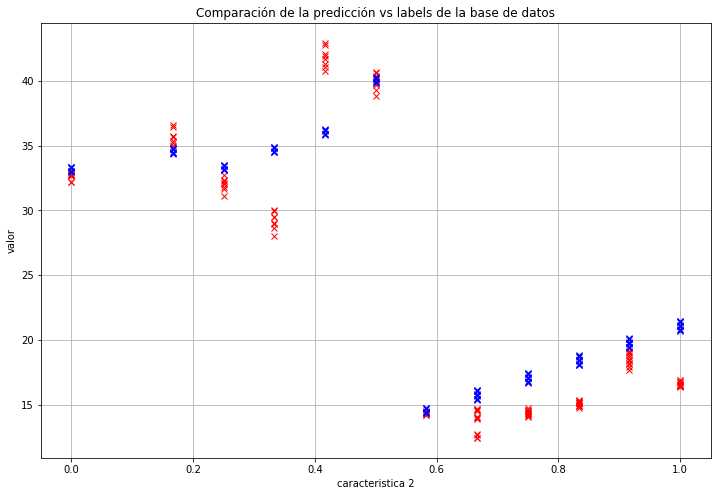

In [9]:
plt.rcParams['figure.figsize'] = (12,8)
plt.grid()
c = 1
plt.plot(X_test[:,c],y_test,'rx')
plt.plot(X_test[:,c],prediction_testing,'bx')
plt.title('Comparación de la predicción vs labels de la base de datos')
plt.xlabel('caracteristica '+ str(c+1))
plt.ylabel('valor')
plt.show()